# Predicting Denmark electricity prediction

## Introductoin
# Introduction to the Energinet Dataset

This project leverages a comprehensive dataset provided by Energinet, the Danish Transmission System Operator. The dataset is publicly available at [DTU Data](https://data.dtu.dk/articles/dataset/Hourly_timeseries_data_of_wind_and_solar_power_production_as_well_as_electricity_consumption_for_all_of_Denmark_from_the_Danish_TSO_Energinet/7599629) and is a part of Denmark's initiative to promote transparency and innovation in energy data.

## Dataset Overview

The Energinet dataset provides hourly timeseries data, encompassing several key aspects:

- **Wind Power Production**: This includes data on the electricity generated from wind turbines. Denmark is a global leader in wind energy, making this dataset particularly valuable for understanding wind power dynamics.

- **Solar Power Production**: The dataset includes information on electricity produced from solar power sources, contributing to insights on renewable energy trends and solar power contributions.

- **Electricity Consumption**: It details the electricity consumption patterns across Denmark, offering a window into consumer behavior and demand trends.

## Purpose and Application

This dataset serves as a vital resource for a wide range of applications:

- **Energy Research**: It enables researchers to analyze patterns, trends, and correlations in renewable energy production and consumption.

- **Policy Making**: Policymakers can use this data to understand the impact of renewable energy and make informed decisions.

- **Machine Learning Projects**: The dataset is ideal for forecasting models, such as predicting energy production or consumption patterns.

For detailed tutorials and usage examples related to this dataset, please refer to the [FANFARE Project Tutorials](https://kpolsen.github.io/FANFARE/tutorials.html).

---

In the following sections of this Jupyter Notebook, we will delve into data wrangling, exploratory data analysis, and model building using this rich dataset.


**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Analyzed the ACF for each feature
- Plot the Pie chart and bar chart
  
  
**3. Modelling** 
- Augmented Dickey-Fuller Test
- Train-Test Split
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Exponential Smoothing Model
- The SARIMAX model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    


In [1]:
"""
Source: https://data.dtu.dk/articles/dataset/Hourly_timeseries_data_of_wind_and_solar_power_production_as_well_as_electricity_consumption_for_all_of_Denmark_from_the_Danish_TSO_Energinet/7599629

https://kpolsen.github.io/FANFARE/tutorials.html
"""


'\nSource: https://data.dtu.dk/articles/dataset/Hourly_timeseries_data_of_wind_and_solar_power_production_as_well_as_electricity_consumption_for_all_of_Denmark_from_the_Danish_TSO_Energinet/7599629\n\nhttps://kpolsen.github.io/FANFARE/tutorials.html\n'

### Importing Required Libraries for Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

### Loading the data

In [3]:
# Parse the XML file
tree = ET.parse('Electricity_Balance_Data_2011-2019_DK1.xml')
root = tree.getroot()

# Extract data into a list of dictionaries
data = []
for row in root.findall('row'):
    row_data = {elem.tag: elem.text for elem in row}
    data.append(row_data)

# Convert to DataFrame
df = pd.DataFrame(data)

# Replace 'NULL' with np.nan
df.replace('NULL', np.nan, inplace=True)

# Convert columns to appropriate data types
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'])
# Now df is your DataFrame with the data

### Initial Data Check

In [4]:
df.head()

,HourUTC,HourDK,PriceArea,GrossCon,NetCon,LocalPowerProd,OffshoreWindPower,OnshoreWindPower,CentralProd,ElectricBoilerCon,SolarPowerProd,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
0,2019-08-31 23:00:00+00:00,2019-09-01 01:00:00,DK1,157.47984,NaN,194.053004,523.642993305,712.005278695,0.0,6.372556,0.0,1400.16,-577.7,-664.98
1,2019-08-31 22:00:00+00:00,2019-09-01 00:00:00,DK1,455.634,NaN,193.213026,483.032189691,500.006891309,0.0,6.650721,0.0,869.46,-448.2,34.374
2,2019-08-31 21:00:00+00:00,2019-08-31 23:00:00,DK1,1782.291792,1713.587704,190.717364,368.154472081,434.995955919,0.0,6.583338,0.0,356.37,-265.4,697.454
3,2019-08-31 20:00:00+00:00,2019-08-31 22:00:00,DK1,1893.416932,1832.170807,208.813786,247.38465896,480.71828704,0.0,6.6028,0.0,181.89,-84.9,859.51
4,2019-08-31 19:00:00+00:00,2019-08-31 21:00:00,DK1,2023.699659,1957.642103,315.890307,192.141402534,398.708000466,3.562949,6.548164,0.0,238.42,-37.6,912.577


### Checking the size of the data

In [5]:
df.shape

(75960, 14)

### Dealing Missing Values

In [6]:
df.isnull().sum()

HourUTC                        0
HourDK                         0
PriceArea                      0
GrossCon                       0
NetCon                         2
LocalPowerProd                 0
OffshoreWindPower              0
OnshoreWindPower               0
CentralProd                    0
ElectricBoilerCon          26304
SolarPowerProd             25968
ExchangeContinent              0
ExchangeGreatBelt              0
ExchangeNordicCountries        0
dtype: int64

In [7]:
# Replace NaN values with zeros in specified columns
df['ElectricBoilerCon'].fillna(0, inplace=True)
df['SolarPowerProd'].fillna(0, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

HourUTC                    0
HourDK                     0
PriceArea                  0
GrossCon                   0
NetCon                     0
LocalPowerProd             0
OffshoreWindPower          0
OnshoreWindPower           0
CentralProd                0
ElectricBoilerCon          0
SolarPowerProd             0
ExchangeContinent          0
ExchangeGreatBelt          0
ExchangeNordicCountries    0
dtype: int64

# Electricity Balance Data Variables

The DataFrame `df` contains several variables related to electricity data in Denmark. Here's a breakdown of each variable:

## Variables

1. **HourUTC**
   - **Description**: Time in Coordinated Universal Time (UTC) for each data entry.
   - **Type**: `datetime`

2. **HourDK**
   - **Description**: Local time in Denmark for the data entry.
   - **Type**: `datetime`

3. **PriceArea**
   - **Description**: Pricing area for the electricity data, 'DK1' in this dataset.
   - **Type**: `string`

4. **GrossCon**
   - **Description**: Gross Electricity Consumption.
   - **Type**: `float`

5. **NetCon**
   - **Description**: Net Electricity Consumption.
   - **Type**: `float`

6. **LocalPowerProd**
   - **Description**: Total local power production.
   - **Type**: `float`

7. **OffshoreWindPower**
   - **Description**: Power produced from offshore wind sources.
   - **Type**: `float`

8. **OnshoreWindPower**
   - **Description**: Electricity generated from onshore wind sources.
   - **Type**: `float`

9. **CentralProd**
   - **Description**: Electricity produced from central power production facilities.
   - **Type**: `float`

10. **ElectricBoilerCon**
    - **Description**: Consumption of electricity by electric boilers.
    - **Type**: `float`

11. **SolarPowerProd**
    - **Description**: Production of electricity via solar power sources.
    - **Type**: `float`

12. **ExchangeContinent**
    - **Description**: Electricity exchanged with the continental power grid.
    - **Type**: `float`

13. **ExchangeGreatBelt**
    - **Description**: Electricity exchange through the Great Belt in Denmark.
    - **Type**: `float`

14. **ExchangeNordicCountries**
    - **Description**: Electricity exchange with Nordic countries.
    - **Type**: `float`

Each variable is crucial for understanding the dynamics of electricity balance in Denmark, including aspects of production, consumption, and exchange.


### Elimination of Redundant Columns

In [8]:
df.drop('HourDK', inplace=True, axis=1)
df.drop('PriceArea', inplace=True, axis=1)
df.set_index(['HourUTC'], inplace=True)

### Setting Data Frequency to Hourly

In [9]:
# Resample the data to ensure an hourly frequency
df = df.resample('H').sum()  # 

# set the freq of index column
df.index.freq = 'H'

### Converting Numeric Values to Appropriate Formats

In [10]:
# List of columns to convert to numeric
numeric_columns = ['GrossCon', 'NetCon', 'LocalPowerProd', 'OffshoreWindPower', 
                   'OnshoreWindPower', 'CentralProd', 'ElectricBoilerCon', 
                   'SolarPowerProd', 'ExchangeContinent', 'ExchangeGreatBelt', 
                   'ExchangeNordicCountries']

# Convert each column to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [11]:
df.head()

,GrossCon,NetCon,LocalPowerProd,OffshoreWindPower,OnshoreWindPower,CentralProd,ElectricBoilerCon,SolarPowerProd,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,
2010-12-31 23:00:00+00:00,2204.6,2112.8,450.7,618.093464,1926.581694,1237.0,0.0,0.0,-477.5,-408.6,-1141.6
2011-01-01 00:00:00+00:00,2129.5,2040.2,436.4,621.428703,1883.371297,1083.2,0.0,0.0,-434.3,-309.0,-1151.6
2011-01-01 01:00:00+00:00,2033.9,1946.7,431.4,615.024796,1760.675204,917.0,0.0,0.0,-354.0,-297.0,-1039.3
2011-01-01 02:00:00+00:00,1950.0,1863.2,429.2,613.623262,1744.176738,880.8,0.0,0.0,-366.5,-330.3,-1020.9
2011-01-01 03:00:00+00:00,1904.2,1818.1,428.7,609.550003,1749.849997,886.2,0.0,0.0,-361.5,-300.5,-1108.1


# Exploratory Data Analysis: Visual Overview of Denmark's Electricity Data

## GrossCon' vs 'NetCon' Patterns and Discrepancies

<AxesSubplot:xlabel='HourUTC'>

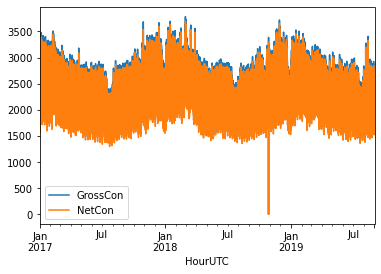

In [12]:
df[['GrossCon', 'NetCon' ]]['2017-01-01': '2020-01-01'].plot()

Let's zoom into the data and mark every Friday by vertical dotted lines.

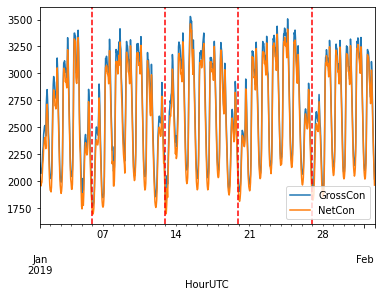

In [13]:

df[['GrossCon', 'NetCon' ]]['2019-01-01': '2019-02-01'].plot()

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

### Computing Autocorrelation for the 'GrossCon' Column

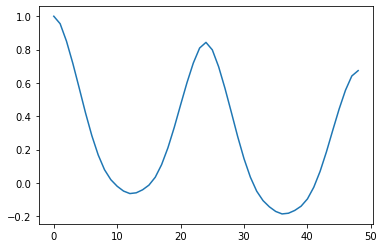

In [14]:
plt.plot(acf(df['GrossCon']))

#### Data Consistency Check: 'GrossCon' vs 'NetCon'
The variables `['GrossCon', 'NetCon']` both follow a similar pattern. The data appears to represent the same quantity. 
The data exhibit seasonal variations and a periodic pattern, without any evident upward or downward trend.

### ToDo:
**Investigate Discrepancy**: Find out why `['GrossCon', 'NetCon']` are not identical!

## Wind Power Generation: Onshore vs Offshore
The plot below displays three years' data for 'OnshoreWindPower' and 'OffshoreWindPower'.


<AxesSubplot:xlabel='HourUTC'>

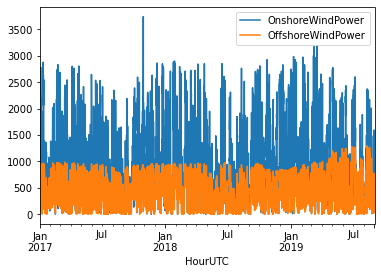

In [15]:
df[['OnshoreWindPower', 'OffshoreWindPower']]['2017-01-01': '2020-01-01'].plot()

<AxesSubplot:xlabel='HourUTC'>

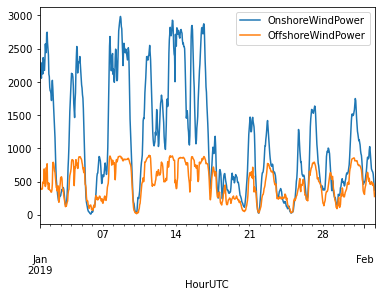

In [16]:
df[['OnshoreWindPower', 'OffshoreWindPower']]['2019-01-01': '2019-02-01'].plot()

### Computing Autocorrelation

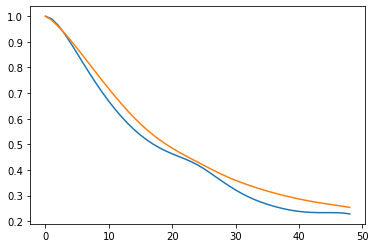

In [17]:
plt.plot(acf(df['OnshoreWindPower']))
plt.plot(acf(df['OffshoreWindPower']))

## Solar Power Production:

<AxesSubplot:xlabel='HourUTC'>

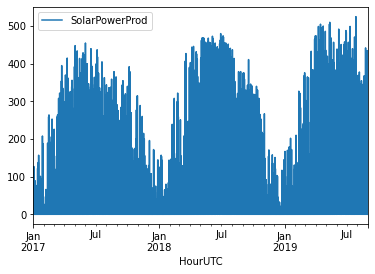

In [18]:
df[['SolarPowerProd']]['2017-01-01': '2020-01-01'].plot()

During January and February, solar power generation reaches its lowest levels. To observe daily trends, we will examine a month's worth of data.

<AxesSubplot:xlabel='HourUTC'>

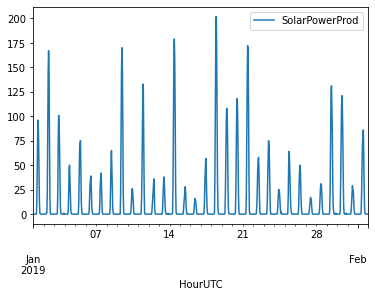

In [19]:
df[['SolarPowerProd']]['2019-01-01': '2019-02-01'].plot()

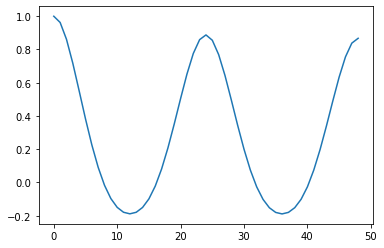

In [20]:
plt.plot(acf(df['SolarPowerProd']))

## Pie chart

In [21]:

def pie_chart(start, end, df):
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    absolute_aggregated_data.drop(['GrossCon', 'NetCon'], inplace=True)
    # Plotting the pie chart
    # absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), title='Energy Distribution for the Selected Period')

    # Explode smaller slices to make them more visible and separate labels
    explode_values = [0.1 if value < 1e6 else 0 for value in absolute_aggregated_data]

    # Plotting the adjusted pie chart
    plt.figure(figsize=(12, 12))  # Increased figure size for better clarity
    absolute_aggregated_data.plot(kind='pie', autopct='%1.1f%%', 
                                  title='Energy Distribution (Excluding GrossCon)', 
                                  explode=explode_values)
    
# Filter data for a specific time period (update this to your desired dates)


### Pie Chart Year 2018

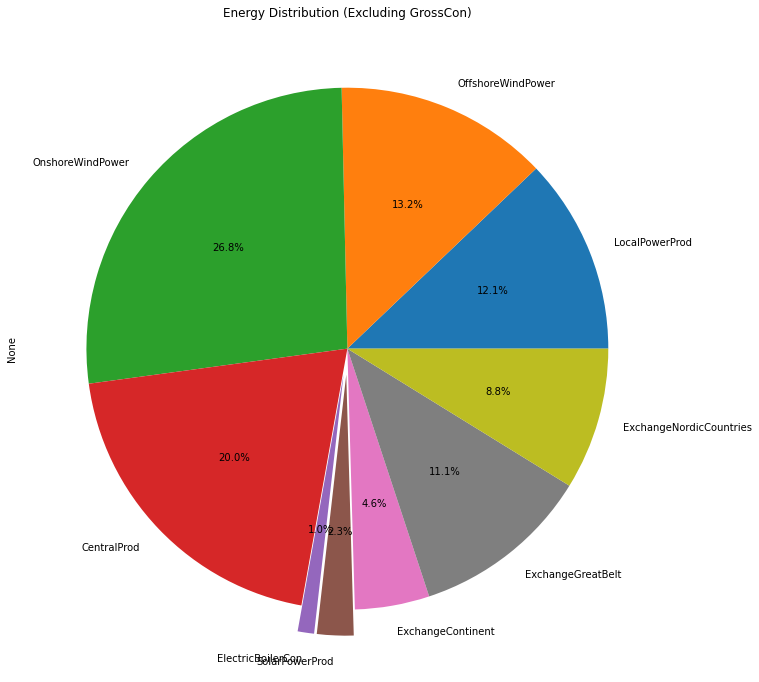

In [22]:
start_date = '2018-01-01'
end_date = '2019-01-01'
pie_chart(start_date, end_date, df)

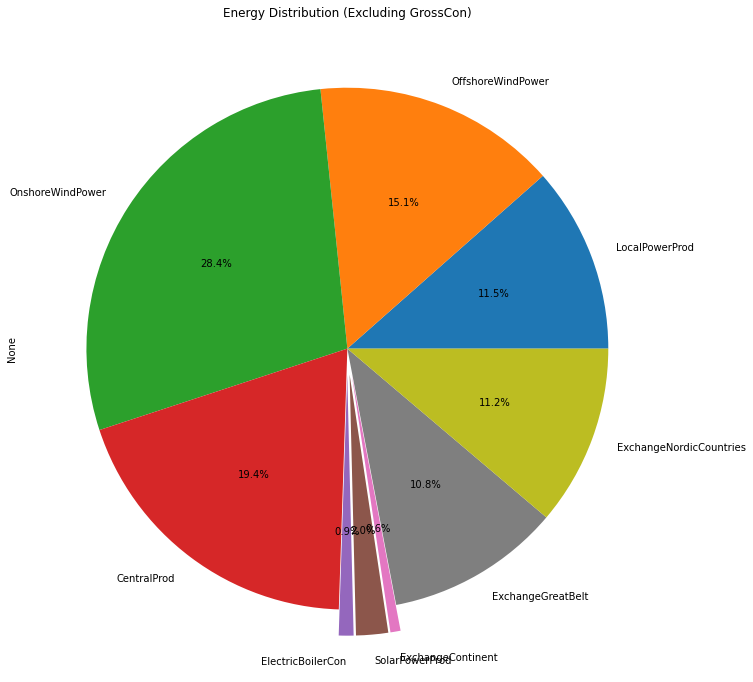

In [23]:
start_date = '2017-01-01'
end_date = '2018-01-01'
pie_chart(start_date, end_date, df)

In [24]:
def bar_chart(start_date, end_date, df):
    # Create a mask for the selected date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Aggregate the data
    aggregated_data = filtered_df.sum()
    # Convert aggregated data to absolute values
    absolute_aggregated_data = aggregated_data.abs()

    # Dropping columns 'GrossCon' and 'NetCon'
    absolute_aggregated_data.drop(['GrossCon', 'NetCon', 'ExchangeContinent', 'ExchangeGreatBelt',
       'ExchangeNordicCountries'], inplace=True)

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    absolute_aggregated_data.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Energy Distribution (Excluding GrossCon)')  # Add title
    plt.xlabel('Energy Types')  # Add x-label
    plt.ylabel('Energy Value')  # Add y-label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


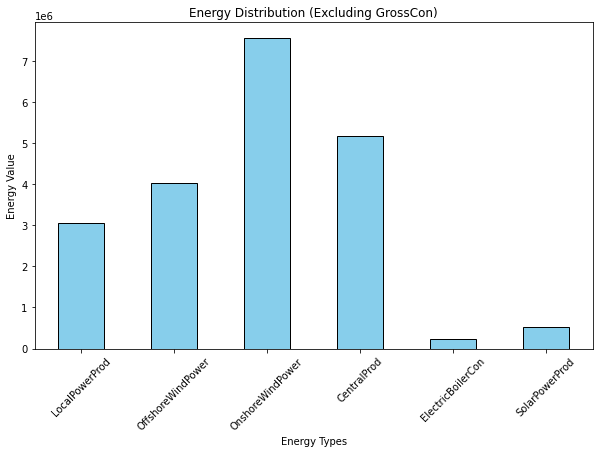

In [25]:
bar_chart(start_date, end_date, df)

The graph presented above illustrates the contributions of various energy segments.

In [26]:


def multi_year_bar_chart(years, df):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Adjust the width of the bars and the spacing between them
    bar_width = 0.2
    spacing = 0.05
    total_width = bar_width * len(years) + spacing * (len(years) - 1)

    # Colors for different years
    colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'crimson', 'deepskyblue', 'gold', 'mediumorchid']


    for i, year in enumerate(years):
        # Creating a mask for each year
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        mask = (df.index >= start_date) & (df.index <= end_date)
        filtered_df = df.loc[mask]

        # Aggregate and process the data
        aggregated_data = filtered_df.sum()
        absolute_aggregated_data = aggregated_data.abs()
        absolute_aggregated_data.drop(['GrossCon', 'NetCon', 'ExchangeContinent', 'ExchangeGreatBelt',
       'ExchangeNordicCountries'], inplace=True)

        # Calculate the offset for each bar
        offset = (np.arange(len(absolute_aggregated_data)) * total_width) + (i * bar_width)

        # Plotting the bars for each year
        plt.bar(x=offset, 
                height=absolute_aggregated_data, 
                width=bar_width, 
                color=colors[i % len(colors)],
                edgecolor='black',
                label=f'{year}')

    # Adjust the x-ticks to be in the center of the group of bars
    plt.xticks(ticks=np.arange(len(absolute_aggregated_data)) * total_width + bar_width, 
               labels=absolute_aggregated_data.index, 
               rotation=45)

    plt.title('Energy Distribution by Year')
    plt.xlabel('Energy Types')
    plt.ylabel('Energy Value')
    plt.legend(title='Year')
    plt.show()

# Sample call to the function with the DataFrame
# Replace this with your actual DataFrame
# multi_year_bar_chart([2017, 2018, 2019], df)



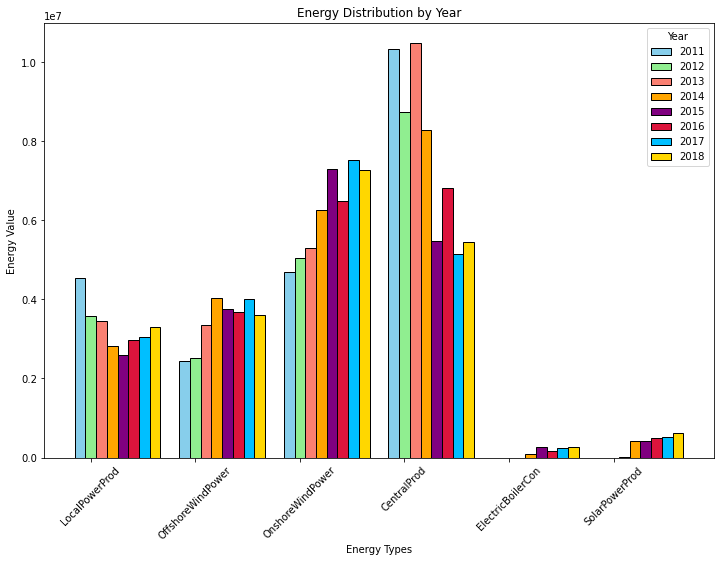

In [27]:
multi_year_bar_chart(range(2011, 2019), df)

Since 2010, there has been an observed increase in the following energy segments: Offshore Wind Power, Onshore Wind Power, Electric Boiler Consumption, and Solar Power Production.
Conversely, there has been a decline in both Local Power Production and Central Production.

# Modeling:
### Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used in time series analysis to determine whether a given time series is stationary or non-stationary. Stationarity is a crucial assumption for many time series modeling techniques.

The code below defines a function `adf_test(series, title='')` that performs the ADF test on a time series and provides a comprehensive report. The function takes the following parameters:

- `series`: The time series to be tested.
- `title` (optional): An optional title to label the ADF test.

The ADF test report includes the ADF test statistic, p-value, the number of lags used in the test, and the number of observations. Additionally, it compares the test statistic to critical values at various significance levels.

The test results are interpreted as follows:
- If the p-value is less than or equal to 0.05, there is strong evidence against the null hypothesis, indicating that the data is stationary, and the null hypothesis is rejected.
- If the p-value is greater than 0.05, there is weak evidence against the null hypothesis, suggesting that the data is non-stationary, and the null hypothesis is not rejected.

This ADF test function is a valuable tool for assessing the stationarity of time series data, a fundamental step in time series analysis and modeling.


In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [29]:
adf_test(df['GrossCon'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -21.634155
p-value                     0.000000
# lags used                63.000000
# observations          75895.000000
critical value (1%)        -3.430436
critical value (5%)        -2.861578
critical value (10%)       -2.566790
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Augmented Dickey-Fuller Test Results**

The Augmented Dickey-Fuller (ADF) test was conducted on the given time series data with the following outcomes:

- **ADF test statistic:** The ADF test statistic value is -21.634155.

- **p-value:** The p-value obtained from the test is 0.000000.

- **Number of lags used:** In the test, 63 lags were utilized.

- **Number of observations:** The total number of observations in the dataset is 75,895.



Based on these test results, the following conclusions can be drawn:

- There is strong evidence against the null hypothesis.

- The null hypothesis is rejected.

- The data exhibits no unit root and is considered stationary.

These findings suggest that the time series data under examination is stationary and does not possess a unit root, which is a crucial characteristic for various time series analysis and modeling techniques.



### Data Splitting into Training and Testing Sets
To prepare our data for modeling and evaluation, we need to split it into training and testing sets. This allows us to train our model on one portion of the data and assess its performance on another. Below is the code to obtain information about the maximum and minimum timestamps in our dataset:

In [30]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())


2019-08-31 21:00:00+00:00
2010-12-31 23:00:00+00:00


Selecting the following date as the dividing point between training and testing data:

In [31]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
train_data = df[:dev_date]
test_data = df[dev_date:]

C:\Users\rasna\AppData\Local\Temp/ipykernel_15424/3684268848.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  train_data = df[:dev_date]
C:\Users\rasna\AppData\Local\Temp/ipykernel_15424/3684268848.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  test_data = df[dev_date:]


### Model Evaluation: Performance Assessment on Test Set

This section focuses on evaluating the model's performance by comparing its predictions against the actual values in the test set. It involves a thorough analysis of how accurately the model has forecasted, using various metrics to assess its effectiveness and reliability when applied to unseen data.

In [32]:
fitted_model = ExponentialSmoothing(train_data['GrossCon'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

C:\Users\rasna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset

In this section, we assess the model's predictive accuracy using the test dataset. The process involves:

1. **Prediction Setup**: 
   - Duration for prediction: 120 days, equivalent to `120 * 24` hours.
   - Calculation of `end_date` by adding the number of hours to `dev_date`.

2. **Extracting Test Data**: 
   - Retrieval of Gross Consumption (`'GrossCon'`) data from `dev_date` to `end_date`.

3. **Generating Forecasts**: 
   - The model forecasts for the defined period (`number_of_hours_to_predict`) are produced and labeled as 'HW_Forecast'.

4. **Comparing Predictions with Actuals**: 
   - The model's forecasts are compared against the actual values in the test data to evaluate accuracy.

This evaluation is crucial to understand the model's effectiveness and reliability in forecasting over the specified time frame.

In [33]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['GrossCon'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


C:\Users\rasna\AppData\Local\Temp/ipykernel_15424/2271161907.py:11: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  y = test_data['GrossCon'][dev_date:end_date]


### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the Gross Consumption values across the training data, test data, and the model's predictions:

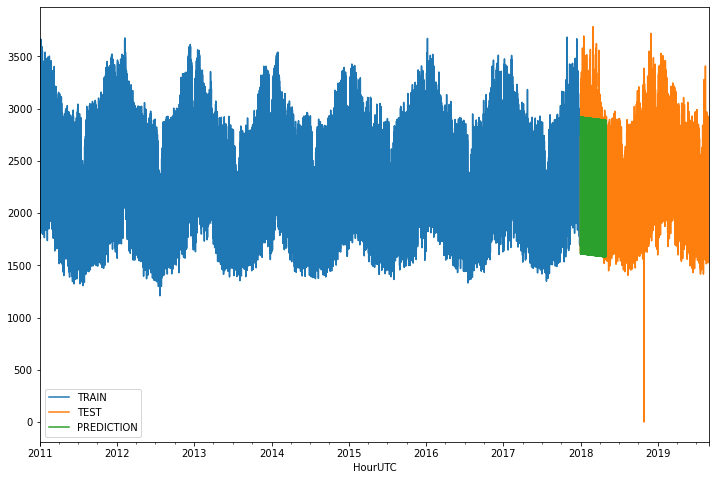

In [34]:
# Plotting the Gross Consumption from the training data
train_data['GrossCon'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['GrossCon'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<AxesSubplot:xlabel='HourUTC'>

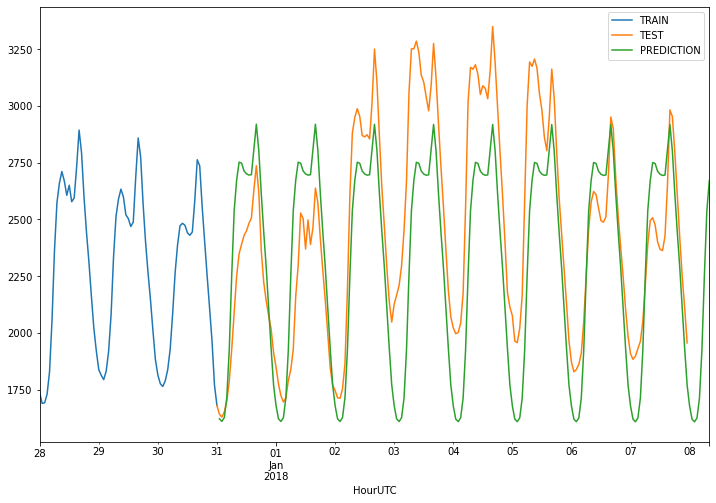

In [35]:
# Plotting the training data
train_data['GrossCon']['2017-12-28':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['GrossCon'][:'2018-01-07'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


The results are unsatisfactory because the predicted values show a downward trend and do not closely resemble the test dataset for longer time periods. Let's assess the results quantitatively.

### Evaluation Metrics
In this section, we will calculate and present various evaluation metrics to assess the performance of our model. We are using the scikit-learn library to compute the following metrics:

#### Mean Absolute Error (MAE):

MAE measures the average absolute difference between the actual values (y) and the predicted values (test_predictions). It provides a measure of the model's accuracy in predicting the target variable.

In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 379.41047256812953


#### Mean Squared Error (MSE):

MSE calculates the average of the squared differences between the actual values and the predicted values. It penalizes larger errors more heavily than MAE.

In [37]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 193060.1217309441


#### Root Mean Squared Error (RMSE):

RMSE is the square root of MSE and provides a measure of the model's error in the same units as the target variable (y).

In [38]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 439.3860736652268


These errors being significant signify that the model is performing poorly. It implies that the model's predictions are not accurately capturing the underlying patterns in the data, and there is room for improvement in the model's predictive capabilities. Further analysis and potentially model refinement may be needed to enhance its performance.

## Forecasting into the Future
### Exponential Smoothing
Although this model exhibited a notably high error, let's assess how it performs in predicting future values.

In [39]:
final_model = ExponentialSmoothing(df['GrossCon'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

C:\Users\rasna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='HourUTC'>

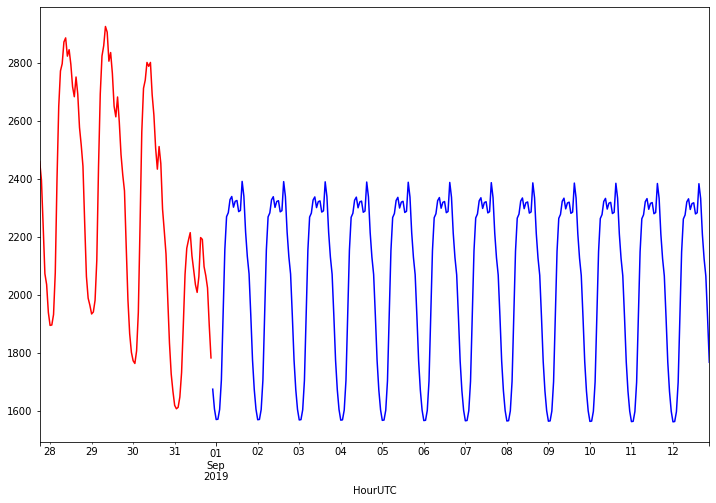

In [40]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
df['GrossCon'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

As anticipated, this model performs inadequately, and the disparity between the actual data and the predicted data is readily apparent upon visual inspection.

## Autoregression (AR) Model

The Autoregression (AR) model is a fundamental time series forecasting technique that is particularly useful when dealing with data exhibiting temporal dependencies. It assumes that future values in a time series can be predicted based on their historical values.

### Key Concepts:

- **Time Dependency:** The AR model captures the idea that each data point in a time series is influenced by its previous observations.

- **Lag Order (p):** The choice of the lag order, denoted as 'p', determines how many past time steps are considered for predicting the future value.

- **Coefficients:** The model estimates coefficients for each lagged value, which govern the strength and direction of the relationship between past observations and the current one.

- **Forecasting:** Once trained, the AR model can make future predictions by applying the learned coefficients to the historical data.

- **Model Evaluation:** Performance evaluation is done using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

- **Limitations:** The AR model assumes linear relationships and may not perform well in complex, nonlinear scenarios.

To use the AR model effectively, you'll need to select an appropriate lag order 'p' and evaluate its performance on your specific time series data. Model selection techniques like AIC and BIC can help with lag order selection.


In [41]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [42]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [43]:
model = AutoReg(train_data['GrossCon'], lags=1)

In [44]:
ARfit = model.fit()

In [45]:
ARfit.params

const          104.628784
GrossCon.L1      0.955047
dtype: float64

In [46]:
# This is the general format for obtaining predictions
start=len(train_data['GrossCon'])
end=len(train_data['GrossCon'])+len(test_data['GrossCon'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<AxesSubplot:xlabel='HourUTC'>

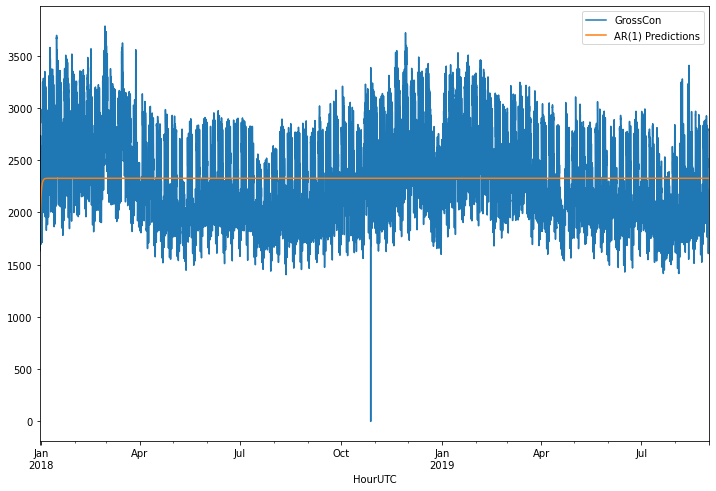

In [47]:
test_data['GrossCon'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [48]:

mae = mean_absolute_error(test_data['GrossCon'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 390.74760304538086


In [49]:
mse = mean_squared_error(test_data['GrossCon'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 215660.9266513853


In [50]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 464.3930734317484


The outcome of this particular model appears to be a flat horizontal line, which indicates that it struggles to capture the fluctuations present in the target variable. Furthermore, the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) all exhibit substantial values, underscoring the model's inadequacy in accurately predicting the target variable. These results collectively suggest that the model's performance is subpar and may require further refinement or the exploration of alternative modeling techniques to better capture the underlying patterns in the data.

## Automated ARIMA Model Selection with `pmdarima`

In time series analysis and forecasting, selecting the appropriate ARIMA model parameters can be a challenging task. The `pmdarima` library provides a convenient and automated way to perform ARIMA model selection.

The code snippet below demonstrates the use of the `auto_arima` function from `pmdarima`. This function automates the process of determining the optimal ARIMA model parameters based on the provided time series data.



In [51]:
# Importing the `auto_arima` function from `pmdarima` library
from pmdarima import auto_arima

# Automated ARIMA Model Selection and Summary

In time series analysis, selecting the optimal ARIMA model parameters can be a crucial step in achieving accurate forecasts. The code snippet below demonstrates the use of the `auto_arima` function to automate the process of finding the best ARIMA model for a given time series.

In [52]:
# Using auto_arima to automatically select the best ARIMA model for 'GrossCon' time series data

# Data input: 'GrossCon' time series data (first 1000 data points)
stepwise_fit = auto_arima(df['GrossCon'][:500], 

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)  


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=7719.302, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=9346.230, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=6631.995, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=5855.093, Time=1.73 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=8.60 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=5849.827, Time=6.78 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=9.41 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.81 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -2682.824
Date:                            Thu, 04 Jan 2024   AIC                           5381.648
Time:                                    08:51:08   BIC                           5415.365
Sample:                                12-31-2010   HQIC                          5394.879
                                     - 01-21-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.1228      5.252      2.118      0.034       0.830      21.416
ar.L1          0.9176      0.015     63.259      0.000       0.889       0.946
ma.L1          0.8584      0.041     21.004      0.000       0.778       0.939
ma.L2          0.2825      0.039      7.289      0.000       0.207       0.358
ar.S.L24       0.9337      0.013     72.989      0.000       0.909       0.959
ma.S.L24      -0.1233      0.052     -2.351      0.019      -0.226      -0.020
ma.S.L48      -0.2755      0.033     -8.297      0.000      -0.341      -0.210
sigma2      2332.9257    106.667     21.871      0.000    2123.863    2541.989
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               523.21
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.41   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1,0,2)(1,0,2)[24] is the best model.

In [53]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['GrossCon'], order=(1, 0, 2), seasonal_order=(1, 0, 2, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()




In [54]:
your_desired_number_of_steps = 24 * 30

# Make future predictions
forecasted_values = model_fit.forecast(steps=your_desired_number_of_steps)

<AxesSubplot:xlabel='HourUTC'>

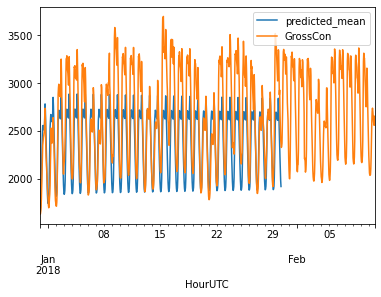

In [55]:
forecasted_values.plot(legend=True)
test_data['GrossCon'][:1000].plot(legend=True)

In [56]:
mae = mean_absolute_error(test_data['GrossCon'][:your_desired_number_of_steps], forecasted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 317.81131419978243


In [57]:
mse = mean_squared_error(test_data['GrossCon'][:your_desired_number_of_steps], forecasted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 147733.21139586568


In [58]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 384.3607828536435


The results suggest that this model exhibits a high level of error, indicating its inadequacy as an effective predictive model.

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

The Seasonal Autoregressive Integrated Moving Average, abbreviated as SARIMA, is an advanced time series forecasting model that extends the capabilities of the ARIMA (Autoregressive Integrated Moving Average) model. SARIMA is specifically designed to handle time series data with recurring seasonal patterns.

### Key Characteristics:

- **Autoregressive (AR) Component:** SARIMA includes an autoregressive component, similar to ARIMA, to capture the relationship between the current value and its past values.

- **Differencing (I):** Like ARIMA, SARIMA may require differencing to make the time series stationary by removing trends and seasonality.

- **Moving Average (MA) Component:** SARIMA incorporates a moving average component to account for the influence of past errors or residuals on the current value.

- **Seasonal Component (S):** What distinguishes SARIMA is its inclusion of seasonal components. These components capture patterns that repeat at regular intervals, making SARIMA suitable for data with strong seasonal trends.

- **Seasonal Differencing (D):** SARIMA allows for seasonal differencing to address seasonal patterns within the data.

- **Model Selection:** Selecting the appropriate SARIMA model involves determining the orders for the AR, I, MA, and seasonal components. This process often requires data analysis and may involve techniques like ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **Forecasting:** Once trained, the SARIMA model can provide future predictions, including point forecasts and prediction intervals.

SARIMA models are valuable tools for handling time series data with complex seasonality, offering accurate forecasts for applications such as sales forecasting, demand prediction, and financial time series analysis. However, effective utilization of SARIMA requires a strong grasp of time series concepts and careful model selection.


### Using the seasonal decomposed data as exogenic parameter in SARIMA. 

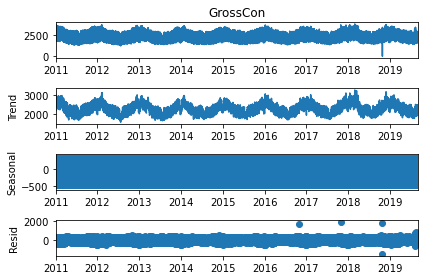

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['GrossCon'], model='additive')  # model='add' also works
result.plot();

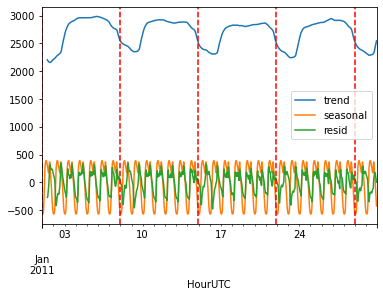

In [60]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<AxesSubplot:xlabel='HourUTC'>

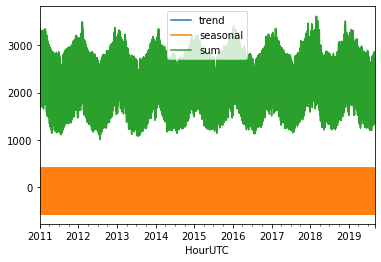

In [61]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [62]:
df_decom_data.head()

,trend,seasonal,sum
HourUTC,,,
2010-12-31 23:00:00+00:00,NaN,-515.752219,NaN
2011-01-01 00:00:00+00:00,NaN,-560.831009,NaN
2011-01-01 01:00:00+00:00,NaN,-571.280149,NaN
2011-01-01 02:00:00+00:00,NaN,-559.424669,NaN
2011-01-01 03:00:00+00:00,NaN,-492.736287,NaN


Creating train and test data sets:

In [63]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
train_data_exo = df[:dev_date]
test_data_exo = df[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]

<AxesSubplot:xlabel='HourUTC'>

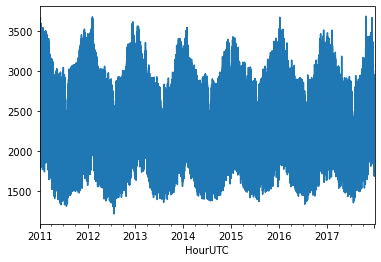

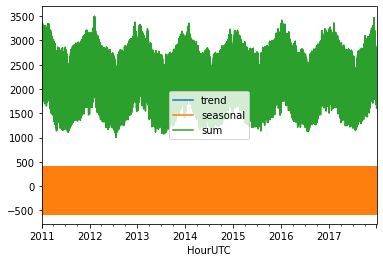

In [64]:
ind = 100000

train_data_exo['GrossCon'][:ind].plot()
df_decom_data_train[:ind].plot()

Fitting the model to the train data set:

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['GrossCon'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 2, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           GrossCon   No. Observations:                  200
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -1083.738
Date:                            Thu, 04 Jan 2024   AIC                           2187.476
Time:                                    09:04:58   BIC                           2220.459
Sample:                                12-22-2017   HQIC                          2200.824
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.4166    334.669      0.001      0.999    -655.522     656.356
seasonal       0.1668    334.666      0.000      1.000    -655.766     656.100
sum            0.5837    334.670      0.002      0.999    -655.358     656.525
ar.L1          0.6659      0.077      8.593      0.000       0.514       0.818
ma.L1          0.3553      0.072      4.965      0.000       0.215       0.496
ma.L2          0.2889      0.084      3.422      0.001       0.123       0.454
ar.S.L24       0.9858      0.074     13.263      0.000       0.840       1.131
ma.S.L24      -0.6839      0.253     -2.700      0.007      -1.180      -0.188
ma.S.L48      -0.1867      0.121     -1.539      0.124      -0.424       0.051
sigma2      2613.9118    472.877      5.528      0.000    1687.090    3540.733
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               148.42
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Preparing the exog_forcast data for prediction purposes:

In [66]:
start_hour = train_data_exo.index.max()
n_hours_to_predict = test_data_exo.shape[0]

end_hour = start_hour + pd.Timedelta(hours=n_hours_to_predict)

delt = end_hour - start_hour
# start_hour = test_data_exo.index.min()
# end_hour = test_data_exo.index.max()


# to find the exog_forecast data we go back n years in data and pick the history 
n_years_back = 3
start_hour_exo_test = start_hour - pd.DateOffset(years=n_years_back)
exog_forecast = df_decom_data_train[start_hour_exo_test: start_hour_exo_test + delt][:-1]

predictions = results.predict(start=start_hour, 
                              end=end_hour, 
                              exog=exog_forecast).rename('SARIMAX(1, 0, 2)(1, 0, 2, 24) Predictions')

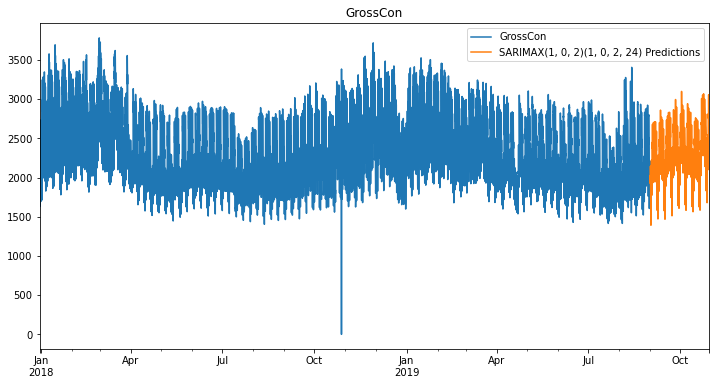

In [83]:
# Plot predictions against known values
title = 'GrossCon'
ylabel=''
xlabel=''

ax = test_data_exo['GrossCon'][:100000].plot(legend=True,figsize=(12,6),title=title)
predictions[:100000].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

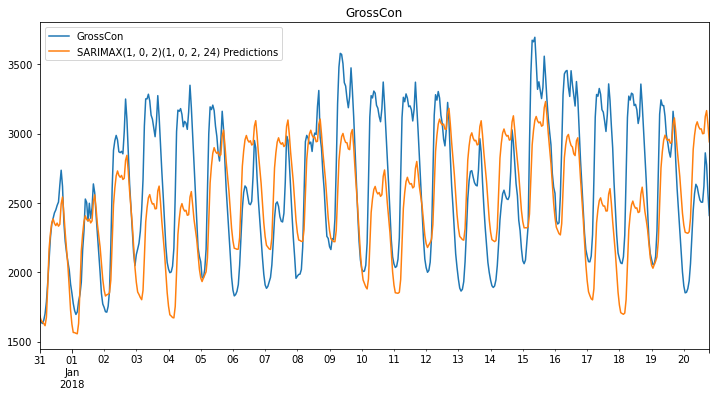

In [76]:
ax = test_data_exo['GrossCon'][:500].plot(legend=True,figsize=(12,6),title=title)

predictions[:500].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [69]:
mae = mean_absolute_error(test_data_exo['GrossCon'], predictions[:-1])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 351.041672489869


In [70]:
mse = mean_squared_error(test_data_exo['GrossCon'], predictions[:-1])
print("Mean Squared Error:", mse)

Mean Squared Error: 176078.13820687184


In [77]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
df.shape

Root Mean Squared Error: 419.61665625529196


(75959, 11)

### Apply on the above method on all of the data:

In [78]:

ind_start = 12 + 50000
ind_end = - 12

model = SARIMAX(df['GrossCon'][ind_start:ind_end],
                exog=df_decom_data[ind_start:ind_end],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 2, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           GrossCon   No. Observations:                25935
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood             -144974.566
Date:                            Thu, 04 Jan 2024   AIC                         289969.132
Time:                                    11:03:56   BIC                         290050.766
Sample:                                09-14-2016   HQIC                        289995.508
                                     - 08-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.4660      1.133      0.411      0.681      -1.756       2.688
seasonal       0.1318      0.118      1.115      0.265      -0.100       0.364
sum            0.5978      1.133      0.528      0.598      -1.623       2.818
ar.L1          0.7069      0.006    127.438      0.000       0.696       0.718
ma.L1          0.1932      0.006     34.732      0.000       0.182       0.204
ma.L2          0.1343      0.005     27.160      0.000       0.125       0.144
ar.S.L24       0.9998   9.77e-05   1.02e+04      0.000       1.000       1.000
ma.S.L24      -0.7236      0.001   -618.751      0.000      -0.726      -0.721
ma.S.L48      -0.1748      0.003    -68.843      0.000      -0.180      -0.170
sigma2      4210.5351      5.497    766.020      0.000    4199.762    4221.308
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):         134956646.98
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             4.19
Prob(H) (two-sided):                  0.00   Kurtosis:                       356.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicting the future:

In [79]:
start_hour = df.index.max()

# Define the prediction horizon
n_years_to_predict = 0
n_months_to_predict = 1
n_day_to_predict = 29
end_hour = start_hour + pd.DateOffset(years=n_years_to_predict, months=n_months_to_predict, days=n_day_to_predict)

print(start_hour, end_hour)
delt = end_hour - start_hour 

print(delt)

print(len(pd.date_range(start_hour, end_hour, freq="H")))
# to find the exog_forecast data we go back n years in data and pick the history 
n_years_go_back = 1
start_hour_exo = start_hour - pd.DateOffset(years=n_years_go_back, months=0, days=0, hours=0)
exog_forecast = df_decom_data[start_hour_exo: start_hour_exo + delt + pd.DateOffset(years=0, months=0, days=0, hours=11)]

print(start_hour_exo, start_hour_exo + delt, exog_forecast.shape)
predictions = results.predict(start=start_hour, 
                              end=end_hour, 
                              exog=exog_forecast).rename('SARIMAX(1, 0, 2)(1, 0, 2, 24) Predictions')

2019-08-31 21:00:00+00:00 2019-10-29 21:00:00+00:00
59 days 00:00:00
1417
2018-08-31 21:00:00+00:00 2018-10-29 21:00:00+00:00 (1428, 3)


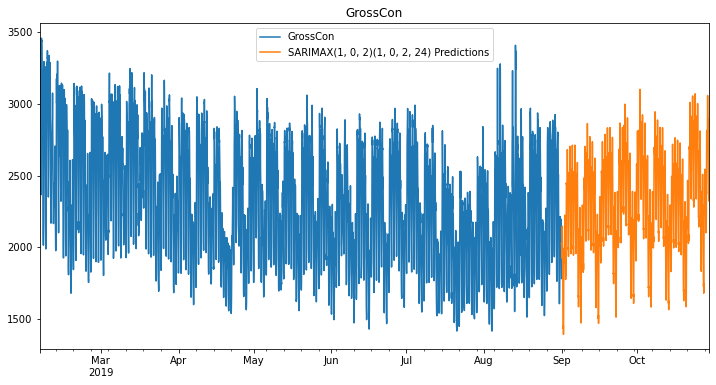

In [81]:
# Plot predictions against known values
title = 'GrossCon'
ylabel=''
xlabel=''

ax = test_data_exo['GrossCon'][-1000:].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);